# What to expect

At the end of notebook 1, we used STAR to map each (cleaned) read file to the reference genome with STAR. In this notebook we will take a look at the outputs generated by STAR for the <i>Schistosoma mansoni</i> dataset. We will guide you through the process of combining the results for each sample in the dataset into a single dataframe and viewing them using Principle Components Analysis. In the second part of this session, you will repeat this process for your choice of dataset in notebook 2B.

# The data

For each dataset, you will find some files stored in `analysis/<dataset>`:

1. `star` folder - contains some of the outputs generated by STAR (others have been omitted to save space)
2. `multiqc` folder - contains a summary of the quality of mappings by STAR

Let's see what we have in this example dataset. 

In [ ]:
ls analysis/Schistosoma_mansoni/*

# Inspect STAR results
[MultiQC](https://multiqc.info/) is a tool which can combine the log files for a bioinformatic analysis over several samples and produce an HTML report summarizing them. It looks a little like the fastQC report from earlier. We have run MultiQC on the set of log files for each dataset and provided it in the analysis subdirectories. Try opening `analysis/Schistosoma_mansoni/multiqc/multiqc_report.html` by double-clicking (you may need to click trust HTML in a banner):

<div class="alert alert-block alert-warning">

Questions:
1. What percentage of reads aligned to the reference (provide a range)?
2. What percentage of reads mapped exactly once in each sample? Does this look reasonable?
3. Are there any samples which look less good? In what way?

<div class="alert alert-block alert-success">
Answers:



# Strandedness

<figure>
    <img src="https://cdn.kastatic.org/ka-perseus-images/1da89713b9aa8067742244d916749e72561bb3cc.png" align="right" width="400">
</figure>

DNA is double stranded with complementary pairs of bases at each position. When when a gene is transcribed, one strand of the DNA serves as the template for the synthesis of a complementary strand of RNA. Genes can be encoded on either strand of the DNA and these RNA transcripts have a polarity (5’ and 3’ ends that are functionally distinct) as this image from the Khan Acadamy shows. A recap on gene transcription can be found [here](https://www.khanacademy.org/science/ap-biology/gene-expression-and-regulation/transcription-and-rna-processing/a/overview-of-transcription).

When this information is preserved by an RNA-Seq experiment, it can help us decide whether a given read has come from a gene on the forward or reverse DNA strand, and this can improve the counts of expressed genes. For example, read 2 in the figure can only come from gene 2, but read 1 could have originated from gene 1 or gene 2.

<div>
<img src="images/strandedness.png" width="500"/>
</div>



To check if our data is stranded, we can inspect the `ReadsPerGene.out.tab` file created by STAR for a sample. STAR maps the reads in both a forward orientation and a reverse orientation. In a stranded forward RNA-Seq library, reads map mostly on the same strand as the genes. With stranded reverse library, reads map mostly on the opposite strand. With unstranded library, reads map on genes on both strands independently of the orientation of the gene.

In the output file, the 3rd column provides the stranded counts, the 4th column the reverse stranded counts and the 2nd column the unstranded counts. If 4th column counts are almost zero, the library is stranded, and if the 3rd column is zero the library is reverse stranded. If neither is mostly zero the library is unstranded.

<div class="alert alert-block alert-warning">

Question:

4. Take a look at `analysis/Schistosoma_mansoni/star/ERR022872/ERR022872ReadsPerGene.out.tab`. Do you think this library was stranded, reverse stranded or unstranded?

<details>
<summary><i>Hint</i></summary>

Use `head` on the command line to view the first few lines of a file. You can set the number of lines with `-n`
</details>

<div class="alert alert-block alert-success">
Answers:



# Combining data across samples

Now that we know the strandedness, we can extract the correct column from this file for each sample and combine them into a single, master dataframe.

The dataframe should have the gene name as index, and a column of reads per gene for each sample. Each column should have the accession number of that sample as column name.

We will create this dataframe using the pandas python library, which you are familiar with. 

<div class="alert alert-block alert-warning">
    
5. Fill the gaps in the code below to create a dataframe containing the relevant counts for each accession

In [ ]:
import pandas as pd

def load_reads_per_gene_df(prefix, strandedness):
    
    accessions = []
    # (1) loop through the list_ids.txt and add each accession to the list without any 
    # whitespace or newline characters

    master_df = None
    
    for accession in accessions:
        print(accession)
        f = f"analysis/{prefix}/star/{accession}/{accession}ReadsPerGene.out.tab"

        # (2) use read_csv to load the results file for this accession
        # use the first column as the index and set the column
        # names to be ["gene", "unstranded", "forward", "reverse"]

        # (3) copy the data from the column corresponding to the correct strandedness
        # to a new column named with the sample accession

        # (4) create a temporary dataframe that contains only the accession column 
    
        # (5) use a dataframe join to add this column to the master dataframe
        # note that the indexes may not be the same

    # (6) remove the first 4 rows of the master dataframe as they contain summary information
    
    # (7) replace empty values with 0

    # save the file
    master_df.to_csv(f"analysis/{prefix}/star/ReadsPerGene.csv")
    return master_df

Test this function on the `Schistosoma_mansoni` dataset and view the result.

In [ ]:
master_df = load_reads_per_gene_df("Schistosoma_mansoni", strandedness)

<details>
<summary><i>Help</i></summary>

If you need to move on, you can load the saved CSV using the following:

    import pandas as pd
    master_df = pd.read_csv(f"analysis/Schistosoma_mansoni/star/ReadsPerGene.csv", index_col=0)
</details>

In [ ]:
master_df

# Normalization
The number of reads mapping to each gene is proportional to the number of expressed transcripts of those genes in each sample. We want to measure which genes are differentially expressed between the different developmental stages. However there are other factors which affect the number of reads mapping such as sequencing depth (which differs between samples) and gene length (which differs between genes) as well as the overall RNA composition (e.g. a small number of very highly expressed genes or a difference in the overall number of genes expressed between samples can skew some methods). Normalization is the process of scaling the raw counts to account for these other factors so that the expression levels are more comparable.

There are [different methods for normalization](https://hbctraining.github.io/DGE_workshop/lessons/02_DGE_count_normalization.html) depending on the comparison we want to perform. For example, an analysis might look within a single sample to see which genes are mostly highly expressed in that sample. It might look at which genes are most highly expressed in a sample group representing a single tissue type or developmental stage. Or it might look at the differential expression (DE) between 2 different sample groups. The following table is taken from this Harvard Chan Bioinformatics Core tutorial:

|                                 Normalization method                                |                                                          Description                                                         |                  Accounted factors                 |                                               Recommendations for use                                               |
|:-----------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------------------------------------------------:|:--------------------------------------------------:|:-------------------------------------------------------------------------------------------------------------------:|
| CPM (counts per million)                                                            | counts scaled by total number of reads                                                                                       | sequencing depth                                   | gene count comparisons between replicates of the same sample group; NOT for within sample comparisons or DE analysis |
| TPM (transcripts per kilobase million)                                              | counts per length of transcript (kb) per million reads mapped                                                                | sequencing depth and gene length                   | gene count comparisons within a sample or between samples of the same sample group; NOT for DE analysis             |
| RPKM/FPKM (reads/fragments per kilobase of exon per million reads/fragments mapped) | similar to TPM                                                                                                               | sequencing depth and gene length                   | gene count comparisons between genes within a sample; NOT for between sample comparisons or DE analysis             |
| DESeq2’s median of ratios                                                      | counts divided by sample-specific size factors determined by median ratio of gene counts relative to geometric mean per gene | sequencing depth and RNA composition               | gene count comparisons between samples and for DE analysis; NOT for within sample comparisons                       |
| EdgeR’s trimmed mean of M values (TMM)                                        | uses a weighted trimmed mean of the log expression ratios between samples                                                    | sequencing depth, RNA composition, and gene length | gene count comparisons between and within samples and for DE analysis                                               |

<div class="alert alert-block alert-warning">

Question:

6. In our analysis we want to see which genes are differentially expressed between 2 groups of samples representing different developmental stages or timepoints. For each of the 5 methods above, state if it would be an appropriate normalization method and why.

<div class="alert alert-block alert-success">
Answers:



In this case, we will use the DESeq2 inbuilt method for normalization. To implement it, we will use the python package [PyDESeq2](https://pydeseq2.readthedocs.io/en/latest/api/index.html). 

This method requires two inputs:

- a count matrix like the one we created before (although it needs to be transposed, so the sample names are in the first column) 
- a metadata table that specifies what each sample is

In [ ]:
#let's create the counts matrix
counts = master_df.T

#lets create the metadata table, and have a look at it
metadata = pd.read_csv("data/Schistosoma_mansoni/metadata.csv", index_col=0)
print(metadata)

In [ ]:
#To start the analysis, let's intall PyDESeq2
! pip install --quiet pydeseq2

# and import the "DeseqDataSet" class from the dds module of PyDESeq2
from pydeseq2.dds import DeseqDataSet

Now, we will use the DeseqDataSet class to create a "dds" object, which is an [AnnData](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.html#anndata.AnnData) object. To create the dds object, we provide some arguments: 

- `counts` is our transposed master_df matrix
- `metadata` is our metadata table that we just created
- `refit_cooks` indicates whether Cook's distance should be recalculated during the analysis. You do not have to worry about the details, we will just indicate that we do want to recalculate Cook's distance.
- `design_factors` is where we indicate what is the factor we want to use to compare samples. In our experiment we want to compare gene expression between the different developmental stages, so we specify "stage" as our design factor

In [ ]:
dds = DeseqDataSet(
    counts=counts,
    metadata=metadata,
    refit_cooks=True,
    design_factors="stage"
)

dds

Once we have created the dds object, we will apply the `deseq2` method to it. This method normalises the data, estimates the dispersion and calculates the log fold change (LFC) based on the design factor.

In [ ]:
dds.deseq2()
dds

<div class="alert alert-block alert-warning">

Question:

7. What new elements have been added to the dds object by the `deseq2` method? How could you view the normed counts?

<div class="alert alert-block alert-success">
Answers:



In [ ]:
# View the normed counts using the following


# PCA Plot

A PCA or Principal Components Analysis plot is a technique to project the gene counts for each sample onto the 2D plane such that they spread out in the two directions that explain most of the differences. The normalized counts for each gene give a different piece of information about the samples. Some genes will be related and so will tell us the same information about the samples, whilst other combinations will tell us more about the differences between samples. A Principal Component Analysis constructs a number of "components" as a linear combination of (normalized) gene counts in order to describe as much of the variation between samples as possible. Plotting the first 2 components can therefore be a useful way to visualize the effect of experimental covariates as well as batch effects.

We are going to use PCA to have a look at our data. We will perform the PCA and create the plot with the python library [scanpy](https://scanpy.readthedocs.io/en/stable/).

In [ ]:
! pip install --quiet scanpy

In [ ]:
import scanpy as sc

# Use scanpy to plot the first 2 components
sc.tl.pca(dds)
sc.pl.pca(dds, size=200, color="stage", annotate_var_explained=True)

<div class="alert alert-block alert-warning">

Questions:

8. Is there a separation of the different developmental stages in the PCA plot?
9. How much variance is explained by the first 2 principle components?
10. What is PC1 separating?
11. What is PC2 separating?

<div class="alert alert-block alert-success">
Answers:



We can look at the loadings associated these components. This will tell us which genes are being given the greatest weight in each component

In [ ]:
sc.pl.pca_loadings(dds, components = '1,2')

<div class="alert alert-block alert-warning">

Question:

12. Which 3 genes contribute most to PC1. Which 2 contribute most to PC2?

<div class="alert alert-block alert-success">
Answers:



# Extension

Restrict to just the cercarium and 24hr life stages and create the PCA plot again.

<details>
<summary><i>Hint</i></summary>

   - Use the `.isin` method to create new counts and metadata matrices that contain only the cercarium and the 24h schristosomulum stages
    
   - Create a new deseq2 object with the new matrices, as we did before
    
   - Generate the PCA plot and loadings figure, as we did before
    
</details>

In [ ]:
# Subset the counts and metadata
counts_s = 
metadata_s = 

# Create the deseq2 object
dds_s = DeseqDataSet(
    counts=
    metadata=
    refit_cooks=True,
    design_factors=
)

# Generate the PCA plot and loadings figure




<div class="alert alert-block alert-warning">

Question:

13. Does PC1 explain more or less of the variance between the subset of groups? Is this what you expect?
14. Are the top 5 ranked genes for PC1 or PC2 the same?

<div class="alert alert-block alert-success">
Answers:



# (Optional) Viewing BAM file with IGV web app
STAR worked by mapping each read to the reference genome for each sample to get the reference coordinates where it best maps. Looking at pile-ups of these reads against the genome can tell us about which parts of the reference genome had greater or lesser coverage and can also show mutations/difference between the reads and the reference sequence.

### The SAM format
The result of this mapping process can be seen on a per-read basis by looking at the SAM (uncompressed) or BAM (compressed) outputs.

### IGV Viewer
To view the pile-up, we will use the IGV web app https://igv.org/app/# First we need to index the reference files and read files using samtools. 
(NB this will not work in Noteable as we need to use the file browser to access the files. We could instead provided URLs to files stored on github)

In [ ]:
%%bash
conda install --yes --quiet  bioconda::samtools
samtools faidx data/Schistosoma_mansoni/reference/schistosoma_mansoni.PRJEA36577.WBPS19.genomic.fa
samtools index analysis/Schistosoma_mansoni/star/ERR022872/ERR022872Aligned.sortedByCoord.out.bam

We will load these files into the genome browser. First select the "Genome" drop-down list. As our references are not in the pre-defined reference list we will select "Local File" and navigate to select both `data/Schistosoma_mansoni/reference/schistosoma_mansoni.PRJEA36577.WBPS19.genomic.fa` and `data/Schistosoma_mansoni/reference/schistosoma_mansoni.PRJEA36577.WBPS19.genomic.fa.fai`
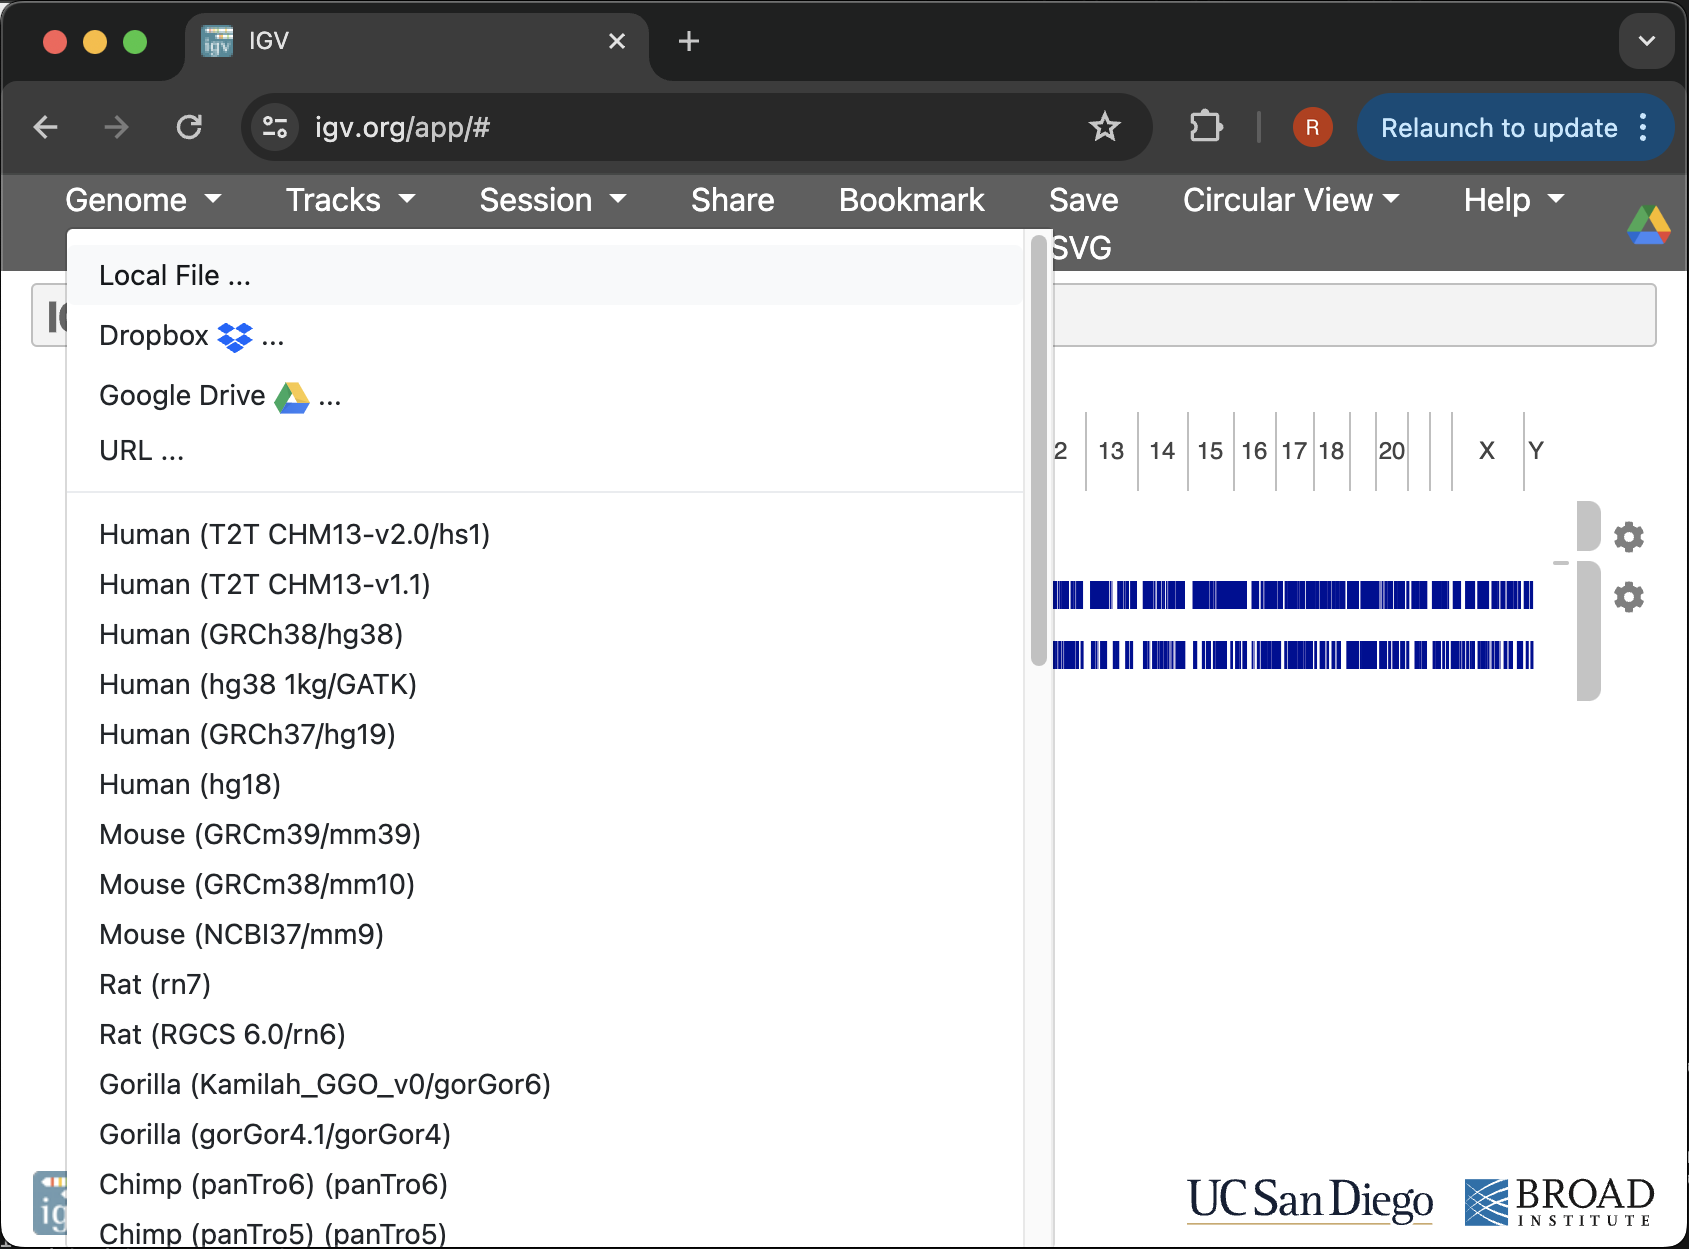

Now select the "Tracks" drop-down list and again select "Local File" and navigate to the GFF3 annotations file `data/Schistosoma_mansoni/reference/schistosoma_mansoni.PRJEA36577.WBPS19.annotations.gff3`
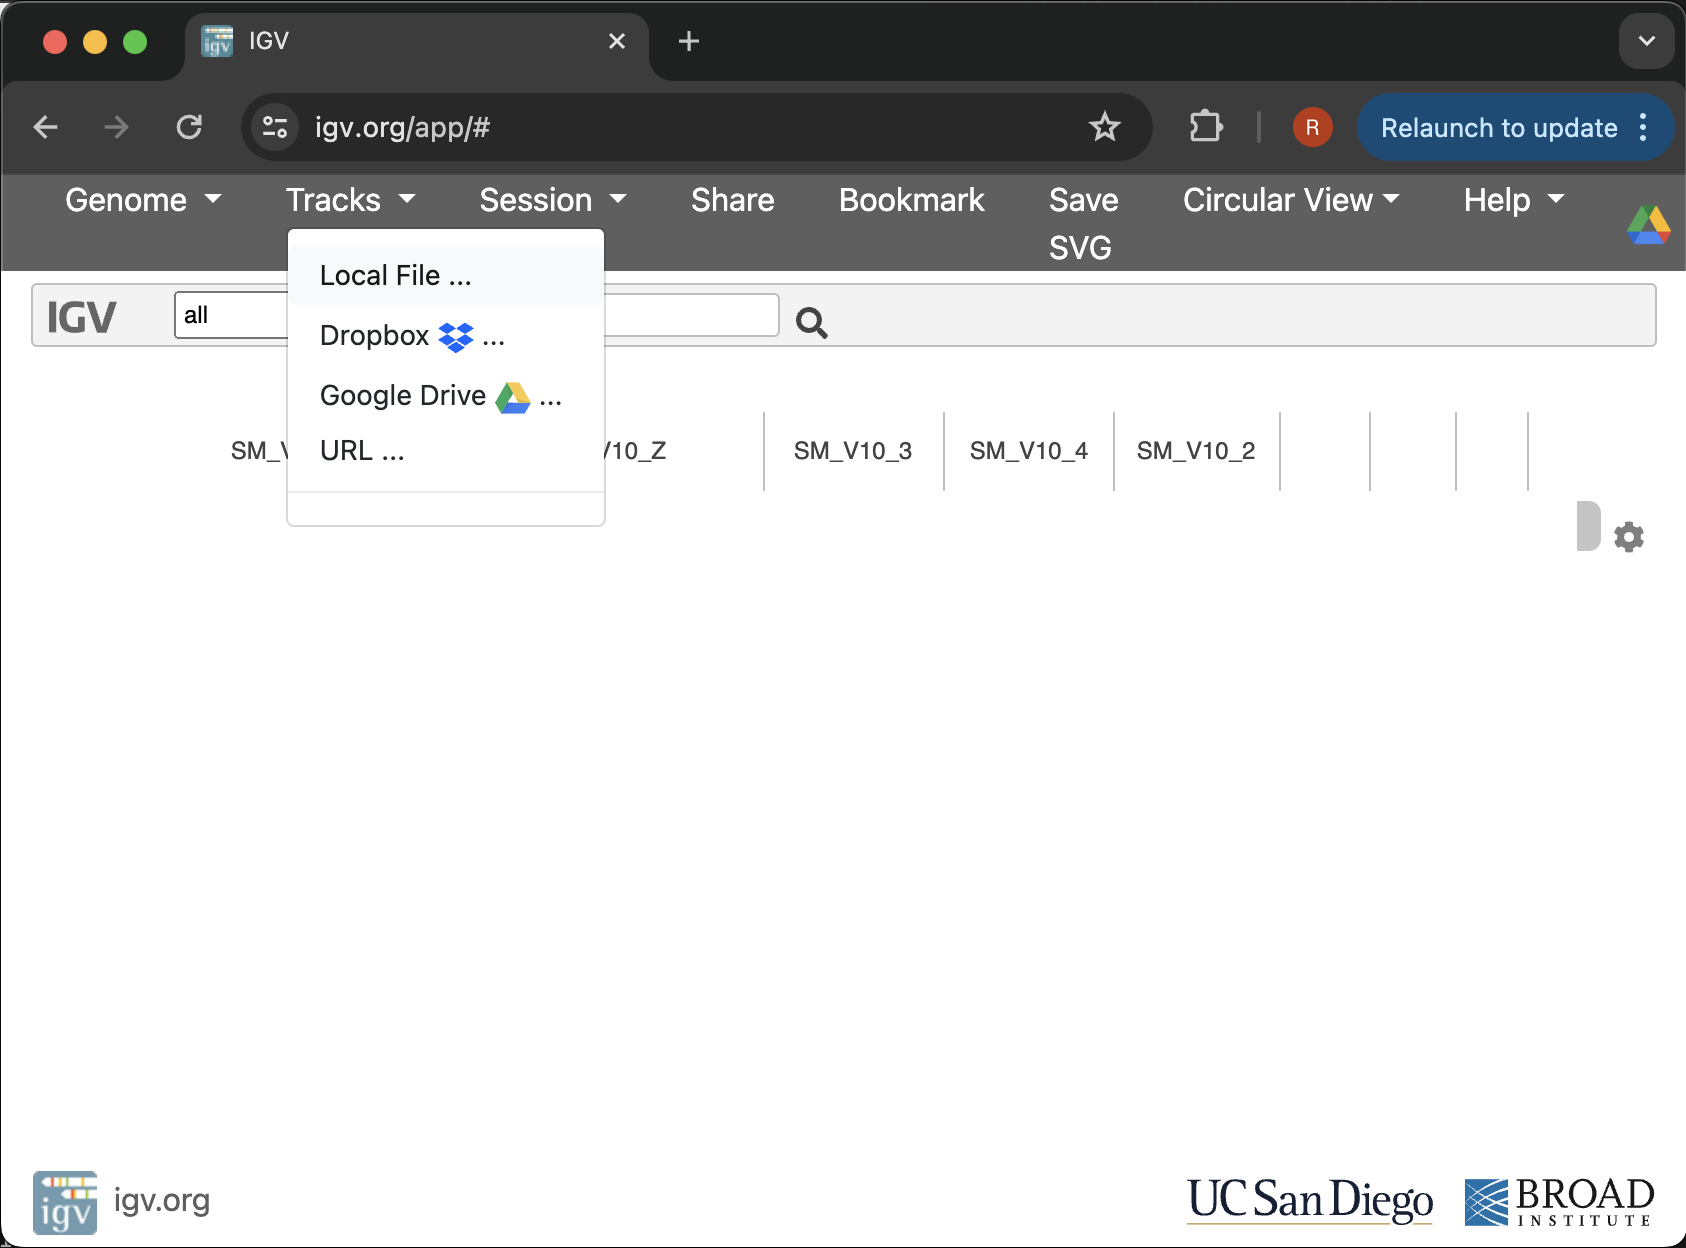

From the "Tracks" drop-down menu again select "Local File" and this time load the reads file and its corresponding `.bai` index. `analysis/Schistosoma_mansoni/star/ERR022872/ERR022872Aligned.sortedByCoord.out.bam` and `analysis/Schistosoma_mansoni/star/ERR022872/ERR022872Aligned.sortedByCoord.out.bam.bai`

Navigate to Gene SM_V10_Z and zoom in to 32,129,000-32,130,000bps and you will be able to see a distinctive spliced mapping pile-up with high coverage over exons and almost none in between.
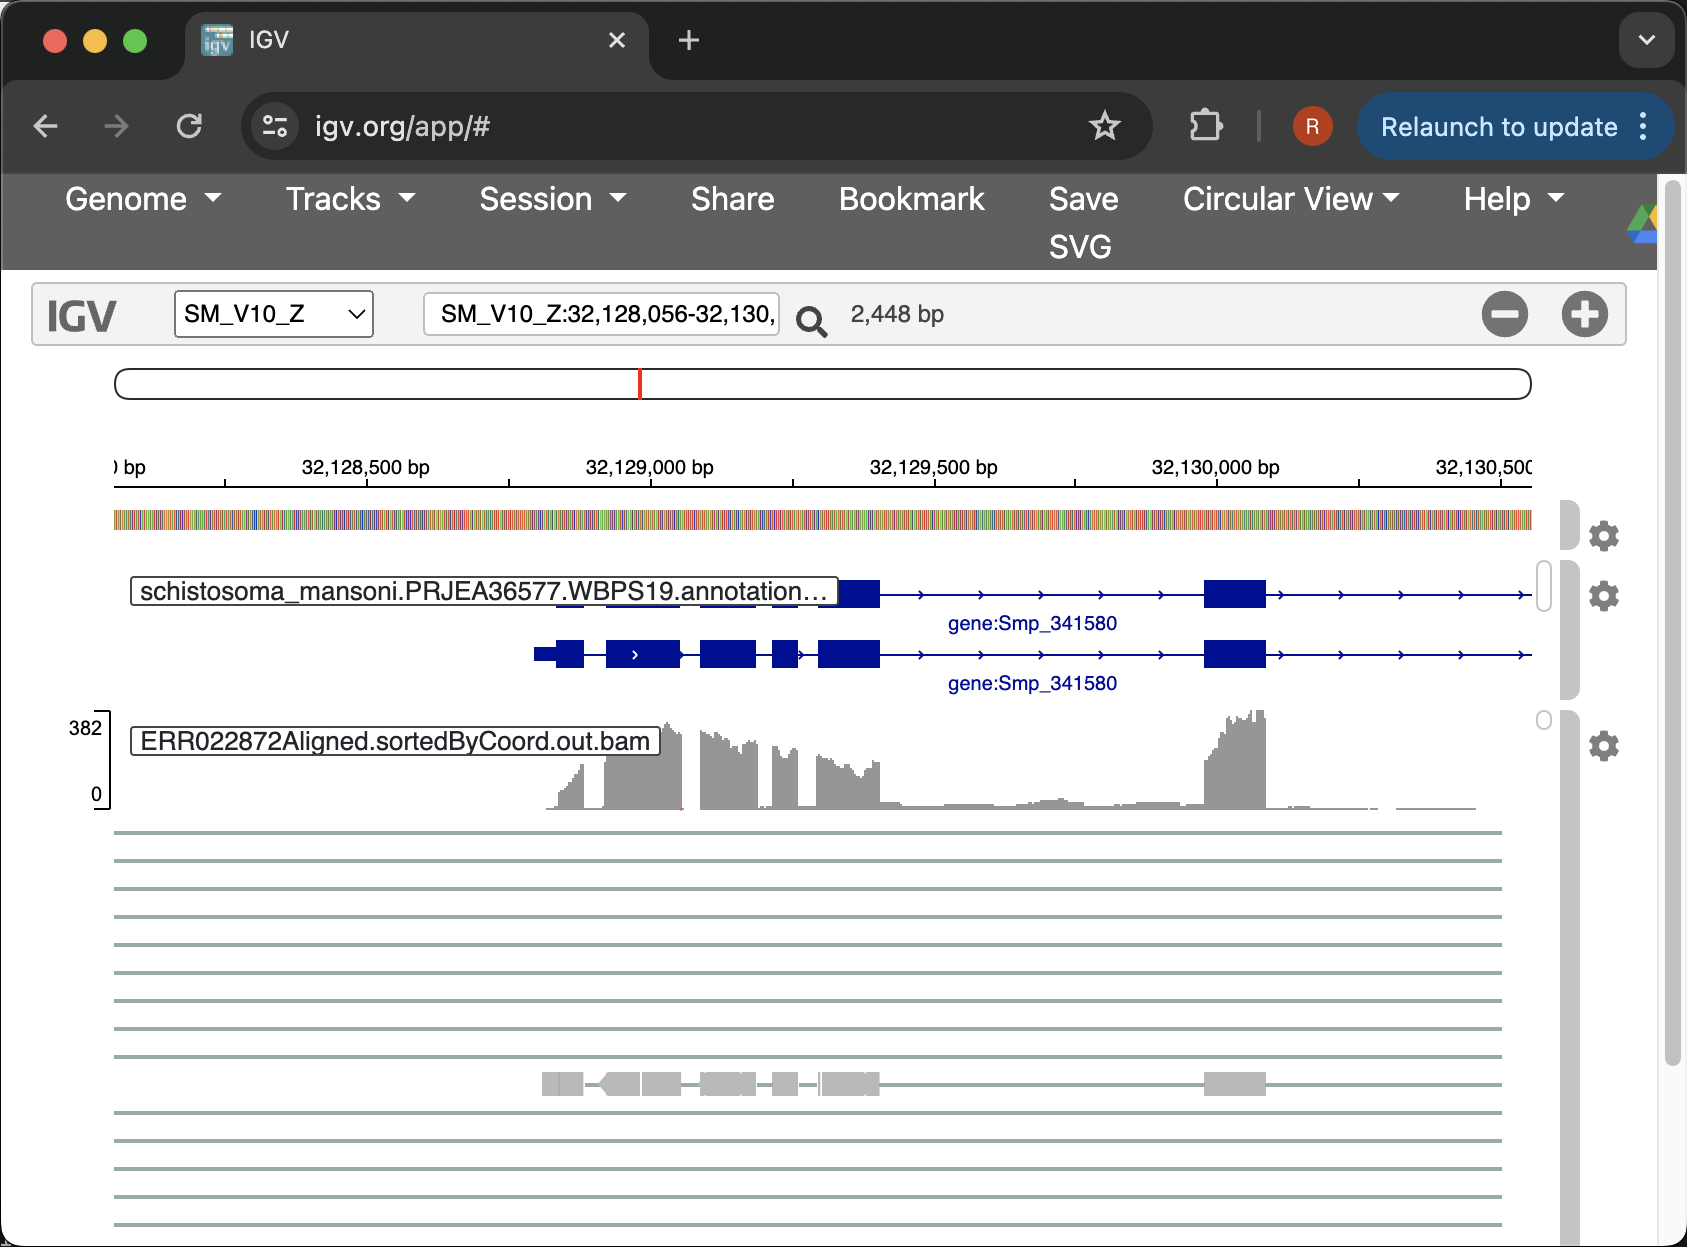